In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%matplotlib widget
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from hdbscan import HDBSCAN

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

from kneed import KneeLocator

In [2]:
data = pd.read_csv("/mnt/Data/code/machine_learning/course/intro_to_ML/intro_to_ML/project/CC GENERAL.csv")
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
data.drop(columns=["CUST_ID"], inplace=True)
columns = data.columns

In [4]:
data.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [5]:
data["CREDIT_LIMIT"].fillna(data["CREDIT_LIMIT"].mode()[0], inplace=True)
data["MINIMUM_PAYMENTS"].fillna(data["MINIMUM_PAYMENTS"].mean(), inplace=True)

In [6]:
data.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [7]:
len(data)

8950

In [8]:
def plot_data(data, title):
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(data)

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2],  linewidth=0.5);
    ax.set_xlabel('Z1')
    ax.set_ylabel('Z2')
    ax.set_zlabel('Z3')
    ax.set_title(title)
    plt.show()

In [9]:
def outlier_detection(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)

    outliers = ( (data < minimum) | (data > maximum) )
    return outliers

In [10]:
def remove_outliers(data, method="knn"):
    columns = data.columns.tolist()
    imp_data = data.copy()

    for column in columns:
        outliers = outlier_detection(imp_data[column])
        
        num_outliers = np.sum( outliers )
        num_total = imp_data[column].count()
        imp_data[column] = imp_data[column].mask(outliers, np.nan)

    if method == "mean":
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    elif method == "median":
        imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    else:
        imputer = KNNImputer(missing_values=np.nan)
        
    imp_data = imputer.fit_transform(imp_data)
    imp_data = pd.DataFrame(imp_data, columns=columns)
    return imp_data

In [11]:
def plot_column_boxplot(data, title):
    columns = data.columns
    fig, axs = plt.subplots(5, 4, figsize=(10, 10))
    fig.tight_layout(pad=2.0)

    for column, ax in zip(columns, axs.flat):
        ax.boxplot(data[column], labels=[column])
    fig.suptitle(title)

In [12]:
def plot_column_hist_line(data, title):
    columns = data.columns
    fig, axs = plt.subplots(5, 4, figsize=(10, 10))
    fig.tight_layout(pad=3.0)

    for column, ax in zip(columns, axs.flat):
        ax.hist(data[column], density=True, alpha=0.5)
        sns.kdeplot(data[column], ax=ax, warn_singular=False)
    fig.suptitle(title)

In [13]:
def remove_skewness(data, method="log1p"):
    columns = data.columns.tolist()
    if method == "sqrt":
        transformer = FunctionTransformer(np.sqrt)
    elif method == "log1p":
        transformer = FunctionTransformer(np.log1p)

    transform_data = transformer.transform(data)
    transform_data = pd.DataFrame(transform_data, columns=columns)
    return transform_data

In [14]:
def normalize(data):
    columns = data.columns.tolist()
    scaler = StandardScaler()
    scaler.fit(data)
    data = scaler.transform(data)
    data = pd.DataFrame(data, columns=columns)
    return data

In [15]:
def reduce_dimensions(data):
    pca = PCA()
    pca.fit(data)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.95) + 1

    columns = ["Z" + str(i) for i in range(1, d+1)]
    
    pca = PCA(n_components=d)
    reduced_data = pca.fit_transform(data)
    reduced_data = pd.DataFrame(reduced_data, columns=columns)
    return reduced_data

In [16]:
def generate_data(data):
    reduce_methods = ["PCA", "none"]
    outliers_methods = ["mean", "median", "knn", "none"]
    unskew_methods = ["sqrt", "log1p", "none"]
    normalize_methods = ["normalize", "no_normalize"]

    return_data = dict()
    for outliers_method in outliers_methods:
        return_data["outlier"] = outliers_method
        if outliers_method == "none":
            return_data["unskew"] = "none"
            return_data['normalize'] = "none"
            return_data["reduce"] = "none"
            return_data["data"] = data
            yield return_data
            break
        else:
            bound_data = remove_outliers(data, method=outliers_method)
        for unskew_method in unskew_methods:
            return_data["unskew"] = unskew_method
            if unskew_method == "none":
                return_data['normalize'] = "none"
                return_data["reduce"] = "none"
                return_data["data"] = bound_data
                yield return_data
                break
            else:
                unskew_data = remove_skewness(bound_data, method=unskew_method)
            for normalize_method in normalize_methods:
                return_data['normalize'] = normalize_method
                if normalize_method == "no_normalize":
                    for reduce_method in reduce_methods:
                        return_data["dimension"] = reduce_method
                        if reduce_method == "none":
                            return_data["data"] = unskew_data
                            yield return_data
                            break
                        else:
                            return_data["data"] = reduce_dimensions(unskew_data)
                            yield return_data
                            break
                else:
                    normalized_data = normalize(unskew_data)
                    for reduce_method in reduce_methods:
                        return_data["dimension"] = reduce_method
                        if reduce_method == "none":
                            return_data["data"] = normalized_data
                            yield return_data
                            break
                        else:
                            return_data["data"] = reduce_dimensions(normalized_data)
                            yield return_data
                            break
    # bound_data = remove_outliers(reduce_data, method=outliers_method)
    # unskew_data = remove_skewness(bound_data, method=unskew_method)
    # normalize_data = normalize(unskew_data)



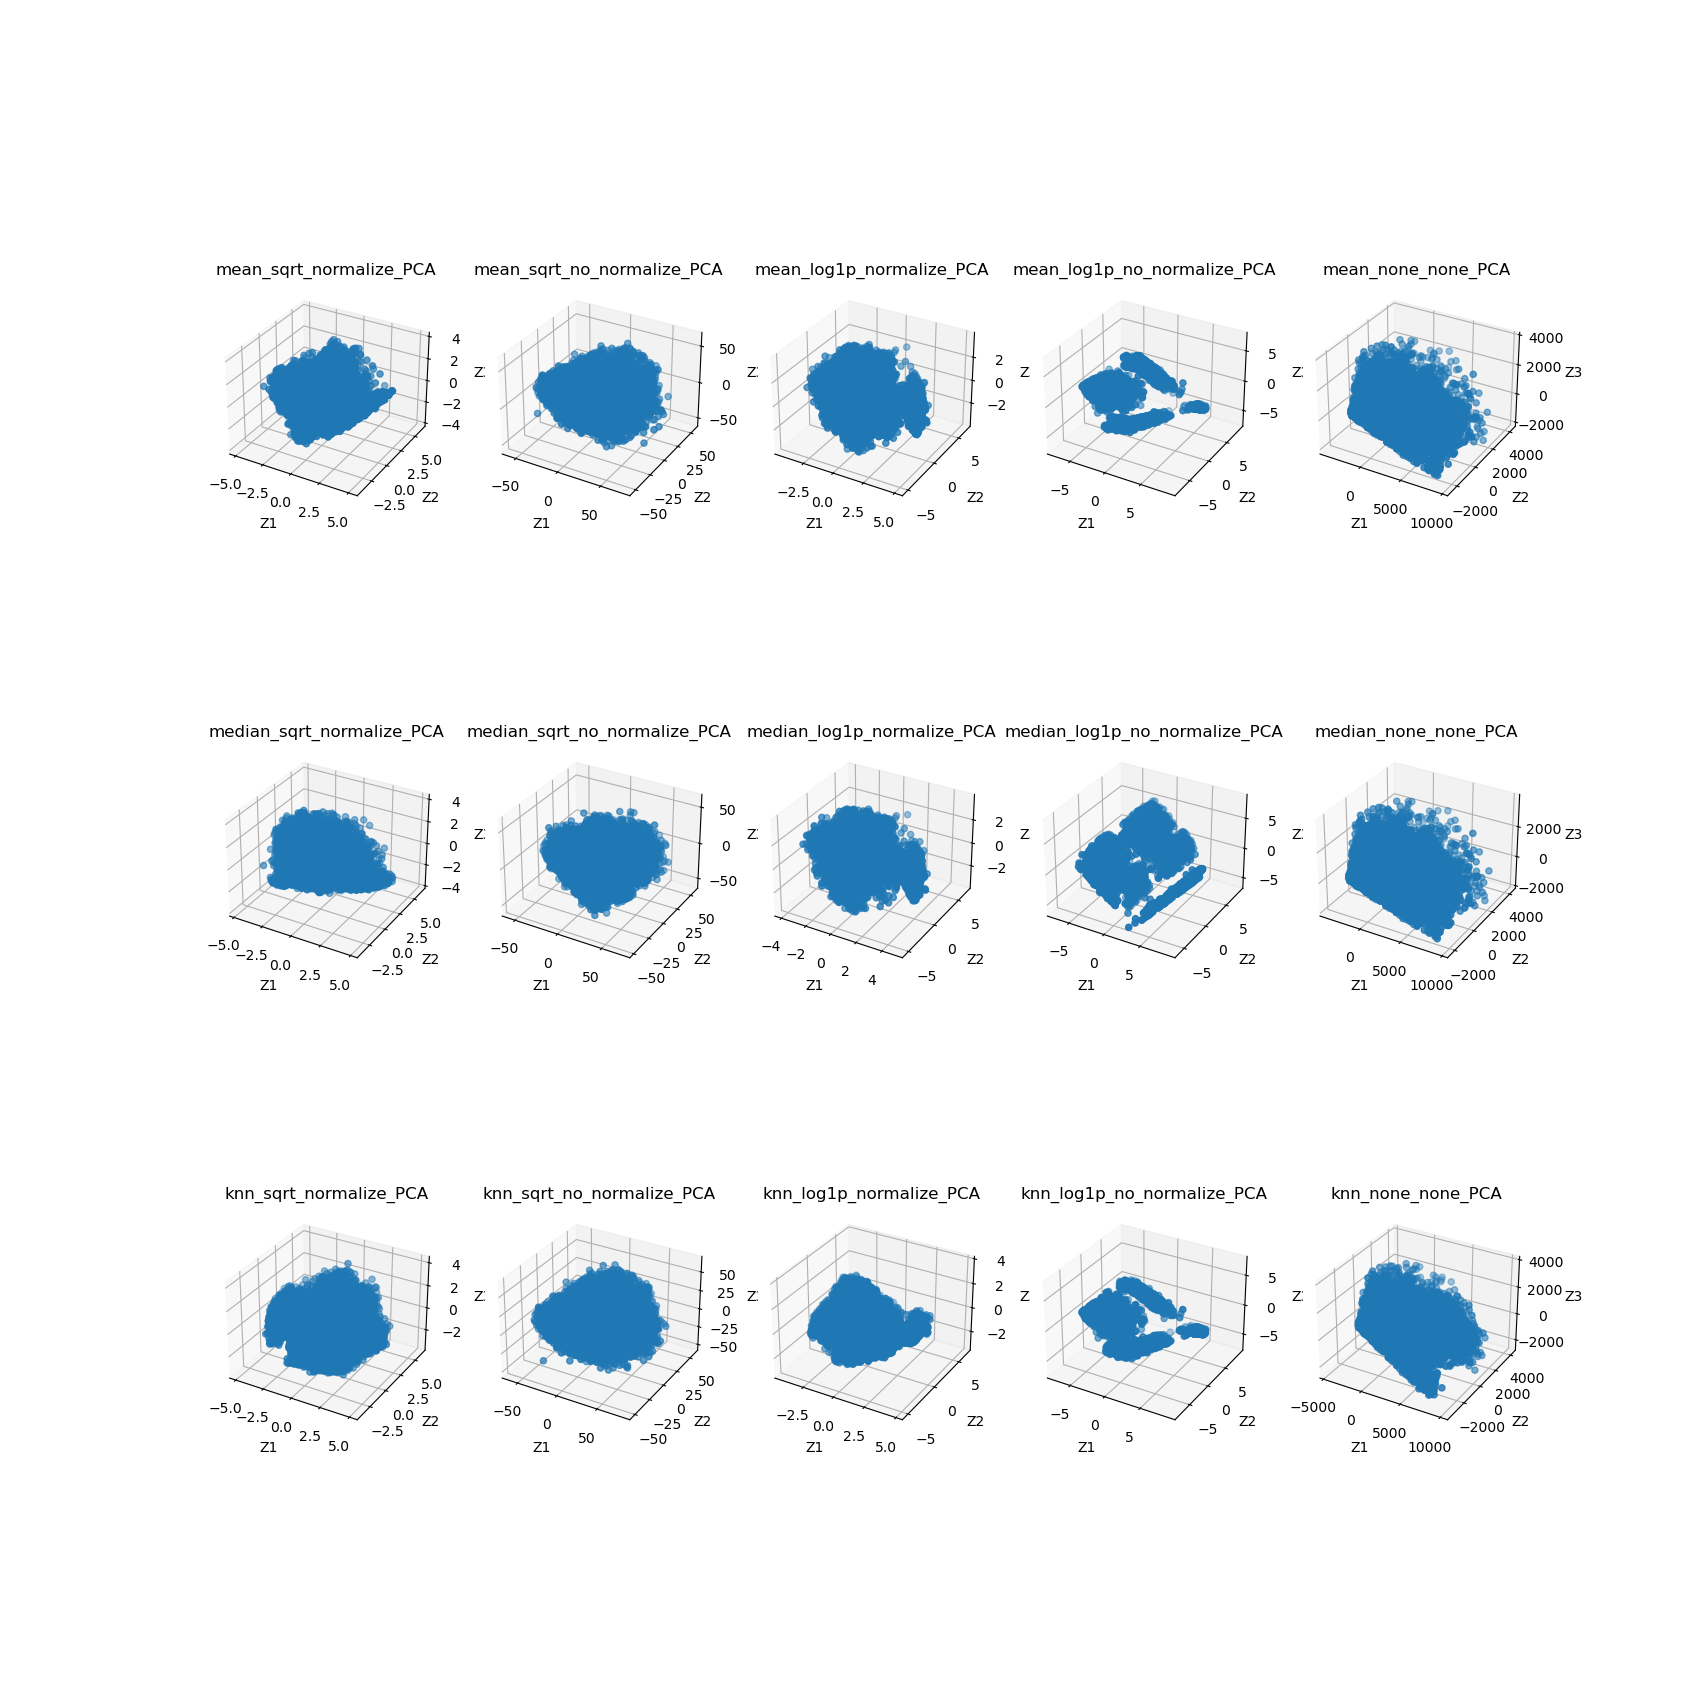

In [19]:
data_gen_fn = generate_data(data)

fig = plt.figure(figsize=(17, 17))
fig.tight_layout(pad=3.0)

count = 1
for X in data_gen_fn:
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(X["data"])
    
    ax = fig.add_subplot(3, 5, count, projection='3d')
    ax.scatter3D(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2])
    ax.set_xlabel('Z1')
    ax.set_ylabel('Z2')
    ax.set_zlabel('Z3')
    ax.set_title(X["outlier"] + "_" + X["unskew"]+ "_" + X["normalize"]+"_" + X["dimension"])
    count += 1
    if count == 16:
        break
plt.savefig("data.png")
plt.show()


In [ ]:
def kmean_clustering_IN(data):
    columns = data.columns.tolist()
    random_states = [10, 20, 30, 40, 50]
    num_clusters = range(2, 21)
    inertia_history = dict()

    for k in num_clusters:
        inertia = list()
        for rs in random_states:
            kmeans = KMeans(n_clusters=k, random_state=rs)
            kmeans.fit(data)
            inertia.append(kmeans.inertia_)
        avg_inertia = np.mean(inertia)
        inertia_history[k] = avg_inertia

    x = list(inertia_history.keys())
    y = list(inertia_history.values())
    kneedle = KneeLocator(x, y, curve="convex", direction="decreasing")
    num_cluster = kneedle.elbow
    print(f"Number of clusters: {num_cluster}")

    kmeans = KMeans(n_clusters=num_cluster, random_state=42)
    y_pred = kmeans.fit_predict(data).reshape(-1, 1)

    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(data)
    X = np.concatenate([X_reduced, y_pred], axis=1)

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    colors = list(mcolors.TABLEAU_COLORS.keys())
    for k in range(num_cluster):
        rows = np.where(X[:, 3] == k)
        ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
    ax.set_xlabel("Z1")
    ax.set_ylabel("Z2")
    ax.set_zlabel("Z3")
    ax.legend()
    plt.show()

    result = pd.DataFrame(np.concatenate([data, y_pred], axis=1), columns=columns + ["Cluster"])
    return result

In [ ]:
data_gen_fn = generate_data(data)
for X in data_gen_fn:
    print(X["dimension"],X["outlier"], X["unskew"], X["normalize"])
    result = kmean_clustering_IN(X["data"])
    result.to_csv(f"{X['dimension']}_{X['outlier']}_{X['unskew']}_{X['normalize']}_kmean.csv")

In [ ]:
def kmean_clustering_DB(data):
    columns = data.columns.tolist()
    random_states = [10, 20, 30, 40, 50]
    num_clusters = range(2, 21)
    score_history = dict()

    for k in num_clusters:
        scores = list()
        for rs in random_states:
            kmeans = KMeans(n_clusters=k, random_state=rs)
            kmeans.fit(data)
            scores.append(davies_bouldin_score(data, kmeans.labels_))
        avg_scores = np.mean(scores)
        score_history[k] = avg_scores

    x = list(score_history.keys())
    y = list(score_history.values())

    num_cluster = x[np.argmin(y)]
    print(f"Number of clusters: {num_cluster}")

    kmeans = KMeans(n_clusters=num_cluster, random_state=42)
    y_pred = kmeans.fit_predict(data).reshape(-1, 1)

    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(data)
    X = np.concatenate([X_reduced, y_pred], axis=1)

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    colors = list(mcolors.CSS4_COLORS.keys())
    for k in range(num_cluster):
        rows = np.where(X[:, 3] == k)
        ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
    ax.set_xlabel("Z1")
    ax.set_ylabel("Z2")
    ax.set_zlabel("Z3")
    ax.legend()
    plt.show()

    result = pd.DataFrame(np.concatenate([data, y_pred], axis=1), columns=columns + ["Cluster"])
    return result

In [ ]:
data_gen_fn = generate_data(data)
for X in data_gen_fn:
    print(X["dimension"],X["outlier"], X["unskew"], X["normalize"])
    result = kmean_clustering_IN(X["data"])
    result.to_csv(f"{X['dimension']}_{X['outlier']}_{X['unskew']}_{X['normalize']}_kmean_db.csv")

In [ ]:
def kmean_clustering_SH(data):
    columns = data.columns.tolist()
    random_states = [10, 20, 30, 40, 50]
    num_clusters = range(2, 21)
    score_history = dict()

    for k in num_clusters:
        scores = list()
        for rs in random_states:
            kmeans = KMeans(n_clusters=k, random_state=rs)
            kmeans.fit(data)
            scores.append(silhouette_score(data, kmeans.labels_))
        avg_scores = np.mean(scores)
        score_history[k] = avg_scores

    x = list(score_history.keys())
    y = list(score_history.values())
    # kneedle = KneeLocator(x, y, curve="convex", direction="decreasing")
    # num_cluster = kneedle.elbow
    num_cluster = x[np.argmax(y)]
    print(f"Number of clusters: {num_cluster}")

    # plt.figure(figsize=(10, 5))
    # plt.plot(x, y)
    # plt.plot(num_cluster, y[num_cluster], "ko")
    # plt.show()

    kmeans = KMeans(n_clusters=num_cluster, random_state=42)
    y_pred = kmeans.fit_predict(data).reshape(-1, 1)

    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(data)
    X = np.concatenate([X_reduced, y_pred], axis=1)

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    colors = list(mcolors.CSS4_COLORS.keys())
    for k in range(num_cluster):
        rows = np.where(X[:, 3] == k)
        ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
    ax.set_xlabel("Z1")
    ax.set_ylabel("Z2")
    ax.set_zlabel("Z3")
    ax.legend()
    plt.show()

    result = pd.DataFrame(np.concatenate([data, y_pred], axis=1), columns=columns+ ["Cluster"])
    return result

In [ ]:
data_gen_fn = generate_data(data)
for X in data_gen_fn:
    print(X["dimension"],X["outlier"], X["unskew"], X["normalize"])
    result = kmean_clustering_IN(X["data"])
    result.to_csv(f"{X['dimension']}_{X['outlier']}_{X['unskew']}_{X['normalize']}_kmean_sh.csv")

In [ ]:
def dbscan_clustering_SH(data):
    columns = data.columns.tolist()
    score_history = dict()
    eps_history = dict()
    min_pts_history = dict()
    min_pts = [5, 10, 20, 50, 100, 200]

    for min_pt in min_pts:
        neighbors = NearestNeighbors(n_neighbors=min_pt)
        neighbors_fit = neighbors.fit(data)

        distances, indices = neighbors_fit.kneighbors(data)
        distances = np.sort(distances, axis=0)
        distances = distances[:, 1]
        indices = range(0, len(distances))

        kneedle = KneeLocator(indices, distances, curve="convex", direction="increasing")
        eps = distances[kneedle.elbow]

        dbscan = DBSCAN(eps=eps, min_samples=min_pt)
        y_pred = dbscan.fit_predict(data)

        k = len(set(y_pred)) - (1 if -1 in y_pred else 0)

        score = silhouette_score(data, y_pred)
        score_history[k] = score
        eps_history[k] = eps
        min_pts_history[k] = min_pt
    
    x = list(score_history.keys())
    y = list(score_history.values())
    num_cluster = x[np.argmax(y)]
    print(f"Number of clusters: {num_cluster}")


    dbscan = DBSCAN(eps=eps_history[num_cluster], min_samples=min_pts_history[num_cluster])
    y_pred = dbscan.fit_predict(data).reshape(-1, 1)
    
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(data)
    X = np.concatenate([X_reduced, y_pred], axis=1)

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    colors = list(mcolors.CSS4_COLORS.keys())
    for k in range(-1,num_cluster):
        rows = np.where(X[:, 3] == k)
        ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
    ax.set_xlabel("Z1")
    ax.set_ylabel("Z2")
    ax.set_zlabel("Z3")
    ax.legend()
    plt.show()

    result = pd.DataFrame(np.concatenate([data, y_pred], axis=1), columns=columns + ["Cluster"])
    return result

        

In [ ]:
data_gen_fn = generate_data(data)
for X in data_gen_fn:
    print(X["dimension"],X["outlier"], X["unskew"], X["normalize"])
    result = kmean_clustering_IN(X["data"])
    result.to_csv(f"{X['dimension']}_{X['outlier']}_{X['unskew']}_{X['normalize']}_dbscan_sh.csv")

In [ ]:
def hierarchical_clustering_SH(data):
    columns = data.columns.tolist()
    num_clusters = range(2, 21)
    score_history = dict()

    for k in num_clusters:
        hierarchical = AgglomerativeClustering(n_clusters=k, compute_distances=True)
        y_pred = hierarchical.fit_predict(data)

        score = silhouette_score(data, y_pred)
        score_history[k] = score
    
    x = list(score_history.keys())
    y = list(score_history.values())
    num_cluster = x[np.argmax(y)]
    print(f"Number of clusters: {num_cluster}")


    hierarchical = AgglomerativeClustering(n_clusters=k, compute_distances=True)
    y_pred = hierarchical.fit_predict(data).reshape(-1, 1)
    
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(data)
    X = np.concatenate([X_reduced, y_pred], axis=1)

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    colors = list(mcolors.CSS4_COLORS.keys())
    for k in range(num_cluster):
        rows = np.where(X[:, 3] == k)
        ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
    ax.set_xlabel("Z1")
    ax.set_ylabel("Z2")
    ax.set_zlabel("Z3")
    ax.legend()
    plt.show()

    result = pd.DataFrame(np.concatenate([data, y_pred], axis=1), columns=columns + ["Cluster"])
    return result

In [ ]:
data_gen_fn = generate_data(data)
for X in data_gen_fn:
    print(X["dimension"],X["outlier"], X["unskew"], X["normalize"])
    result = kmean_clustering_IN(X["data"])
    result.to_csv(f"{X['dimension']}_{X['outlier']}_{X['unskew']}_{X['normalize']}_hierarchical_sh.csv")

In [ ]:
def hdbscan_clustering_SH(data):
    columns = data.columns.tolist()
    min_cluster_sizes = [5, 20, 50, 100, 200]
    score_history = dict()
    min_cluster_history = dict()

    for min_k_size in min_cluster_sizes:
        hdbscan = HDBSCAN(algorithm="best", allow_single_cluster=False, alpha=1.0, approx_min_span_tree=True, cluster_selection_method="eom", core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=4.0, match_reference_implementation=False, metric="euclidean", min_cluster_size=min_k_size, min_samples=None, p=None, prediction_data=False)
        y_pred = hdbscan.fit_predict(data)

        k = len(set(y_pred)) - (1 if -1 in y_pred else 0)

        score = silhouette_score(data, y_pred)
        score_history[k] = score
        min_cluster_history[k] = min_k_size
    
    x = list(score_history.keys())
    y = list(score_history.values())
    num_cluster = x[np.argmax(y)]
    print(f"Number of clusters: {num_cluster}")


    hdbscan = HDBSCAN(algorithm="best", allow_single_cluster=False, alpha=1.0, approx_min_span_tree=True, cluster_selection_method="eom", core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=4.0, match_reference_implementation=False, metric="euclidean", min_cluster_size=min_cluster_history[num_cluster], min_samples=None, p=None, prediction_data=False)
    y_pred = hdbscan.fit_predict(data).reshape(-1,1)
    
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(data)
    X = np.concatenate([X_reduced, y_pred], axis=1)

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    colors = list(mcolors.CSS4_COLORS.keys())
    for k in range(-1,num_cluster):
        rows = np.where(X[:, 3] == k)
        ax.scatter3D(X[rows][:, 0], X[rows][:, 1], X[rows][:, 2], label=f"Cluster {k+1}", color=colors[k])
    ax.set_xlabel("Z1")
    ax.set_ylabel("Z2")
    ax.set_zlabel("Z3")
    ax.legend()
    plt.show()

    result = pd.DataFrame(np.concatenate([data, y_pred], axis=1), columns=columns + ["Cluster"])
    return result

In [ ]:
data_gen_fn = generate_data(data)
for X in data_gen_fn:
    print(X["dimension"],X["outlier"], X["unskew"], X["normalize"])
    result = kmean_clustering_IN(X["data"])
    result.to_csv(f"{X['dimension']}_{X['outlier']}_{X['unskew']}_{X['normalize']}_hdbscan_sh.csv")